## Settings

In [82]:
from imutils.perspective import four_point_transform
from skimage.measure import compare_ssim
from imutils import contours
from os import listdir
import numpy as np
import argparse
import imutils
import cv2

from progressbar import progressbar
from joblib import Parallel, delayed
import multiprocessing
     
from matplotlib import interactive
interactive(True)

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [83]:
import matplotlib.pyplot as plt
def show(img,figsize=(10,10)):

    cmap = plt.cm.OrRd
    cmap.set_bad(color='black')
    
    
    if type(img) != list:
        plt.figure(figsize=figsize)
        plt.imshow(img, cmap='gray')
    else:
        ncols=len(img)
        fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=figsize)
        for i in range(ncols):
            axes[i].imshow(img[i], cmap='gray')
    plt.show()

In [107]:
dot = cv2.imread('dot.png')
dot_h, dot_w, dot_c = dot.shape

def match(img):
    res = cv2.matchTemplate(img,dot,cv2.TM_CCOEFF_NORMED)
    threshold = 0.5
    loc = np.where( res >= threshold)

#     x = set()
#     y = set()
    local_x = 0
    local_y = 0
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img, pt, (pt[0] + dot_w, pt[1] + dot_h), (0,255,255), 1)
#         x.add(pt[0])
#         y.add(pt[1])
        local_x = pt[0]
        local_y = pt[1]
        
        
    return (local_x+dot_w//2,local_y+dot_h//2)
        
def getTips(image, imshow=False):
    
    h,w,c = image.shape
    
    s = int(0.08*h)

    p0 = (int(0.025*h), int(0*w))
    p1 = (int(0.025*h), int(w-s))
    p2 = (int(h)-s, int(0*w))
    p3 = (int(h)-s, int(w-s))

    tips = [p0,p1,p2,p3]
    tests = []

    for n,(y,x) in enumerate(tips):

        test = image[y:y+s, x:x+s].copy()
        gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
        pt = match(test)

        tips[n] = (x+pt[0], y+pt[1])
                
        if imshow: tests += [test]
    if imshow: show(tests)
        
    return np.array(tips)

In [108]:
def option_location(image, imshow=False):
    
    test = image.copy()
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    warped = gray.copy()

    thresh = cv2.threshold(warped, 0,127,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)

    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    ###################################################################
    # loop over the contours
    
    option_cnts = []
    for c in cnts:
        # compute the bounding box of the contour, then use the
        # bounding box to derive the aspect ratio
        (x, y, w, h) = cv2.boundingRect(c)

        _w = _h = 18.5
        
        if(w >= _w and h >= _h and np.abs(w-h)<4): 
            circles = cv2.HoughCircles(gray[y:y+h, x:x+w], 
                                       cv2.HOUGH_GRADIENT, 1,100, 
                                       param1=20,param2=10,minRadius=13,maxRadius=0)
            if circles is not None:
                for i in circles[0,:]:
                    cv2.circle(test[y:y+h, x:x+w],(i[0],i[1]),i[2],(0,255,0),2)
                    cv2.circle(test[y:y+h, x:x+w],(i[0],i[1]),2,(0,255,0),3)
                option_cnts.append(c)
        
    show(test, (10,10))
                
    ###################################################################
    # count marked ops

    # questionCnts = contours.sort_contours(questionCnts,method="left-to-right")[0]
#     option_cnts = contours.sort_contours(option_cnts,method="top-to-bottom")[0]
    
    # print("Pontos identificados:",len(option_cnts))
    return option_cnts

In [109]:
def isdarker(piece, tresh=0.25):
    "this function ..."
    "cluster image colors => copare to tresh hold => return true if image is darker the tresh"
    
    from sklearn.cluster import KMeans

    image = piece.copy()
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray scale vector
    image = image.reshape((image.shape[0] * image.shape[1], 1)) 

    clt = KMeans(n_clusters = 2)
    clt.fit(image)
    centroids =  clt.cluster_centers_

    ## Histogram

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    (pr1, cl1), (pr2, cl2) =  zip(hist, centroids)

    if(cl1[0] < cl2[0] and pr1 >= tresh):
        return True

    if(cl2[0] < cl1[0] and pr2 >= tresh):
        return True
    else:
        return False

In [110]:
def marked_option(croped_image, option_cnts, imshow=True):
    
    croped = croped_image.copy()
        
    # sort the contours for the current question from
    # left to right, then initialize the index of the option Id
    # bubbled answer
    cnts = contours.sort_contours(option_cnts)[0]
    cnts = contours.sort_contours(option_cnts,method="top-to-bottom")[0]
    cnts = contours.sort_contours(option_cnts, method="left-to-right")[0]
    bubbled = None

    # loop over the sorted contours
    marded_opts = list()
    for (j, c) in enumerate(cnts):

        noise = 15
        
        (x, y, w, h) = cv2.boundingRect(c)
        (x, y, w, h) = (x-10, y, w+noise, h+noise)
        piece = croped[y:y+h, x:x+w]
        piece = cv2.fastNlMeansDenoisingColored(piece, None, 50,3)
        markerd = isdarker(piece)

        if(markerd):
            marded_opts.append([(x,y),1])
            color = (0, 255, 0)           
        else:
            marded_opts.append([(x,y),0])
            color = (255, 0, 0)
        

        if(imshow == True):
#             cv2.rectangle(croped, (x, y), (x+w, y+h), (0,0,255), 2)
            cv2.drawContours(croped, [cnts[j]], -1, color, 3)
#             font                   = cv2.FONT_HERSHEY_SIMPLEX
#             bottomLeftCornerOfText = (x,y)
#             fontScale              = 0.5
#             fontColor              = color
#             lineType               = 2

#             cv2.putText(croped, str(j), 
#                 bottomLeftCornerOfText, 
#                 font, 
#                 fontScale,
#                 fontColor,
#                 lineType)
            
    if(imshow == True): show(croped, (10,10))
    return marded_opts

In [111]:
from sklearn.cluster import KMeans
closer = lambda myNumber, myList: min(myList, key=lambda x:abs(x-myNumber))
closer_index = lambda myNumber, myList: np.where(myList==closer(myNumber,myList))[0][0]

def optins2answer_list(marked_options):

    Xs = []
    Ys = []
    for option in marked_options:
        x,y = option[0]
        Xs.append([x])
        Ys.append([y])

    x_means = KMeans(n_clusters=15, random_state=0).fit(Xs)
    y_means = KMeans(n_clusters=24, random_state=0).fit(Ys)

    xs = np.sort([int(x[0]) for x in x_means.cluster_centers_])
    ys = np.sort([int(y[0]) for y in y_means.cluster_centers_])

    answer_table = np.full([len(ys), len(xs)], -1)
    for option in marked_options:
        x,y = option[0]
        answer_table[closer_index(y, ys)][closer_index(x, xs)] = option[1]

    answers =  [list(line[col:col+5]) for col in range(0,15,5) for line in answer_table[:part2]]
    answers += [list(line[col:col+5]) for col in range(0,15,5) for line in answer_table[part2:]]

    abcde = "ABCDE"
    answer_list = []

    for q_line in answers:
        if not(-1 in q_line):
            if sum(q_line) > 1:
                answer_list.append('*')
            elif sum(q_line) == 0:
                answer_list.append('#')
            else:
                answer_list.append(abcde[q_line.index(1)])

    return answer_list

## Load Templates

In [112]:
mult_process = False
imshow = False

PT_AVALIA_40_32_AE.png


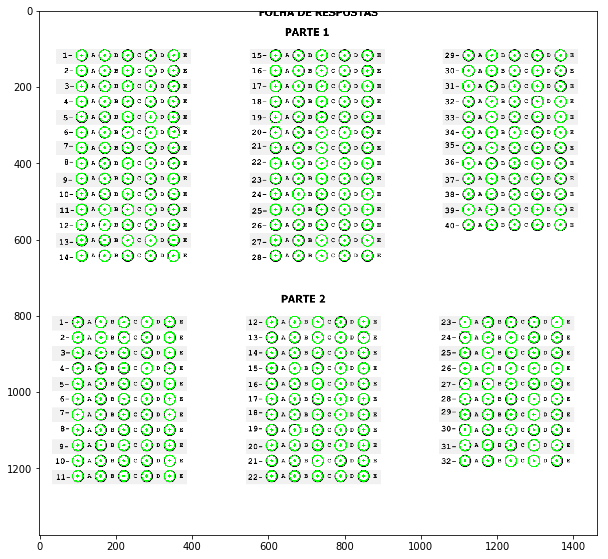

PT_AVALIA_37_32_AE.png


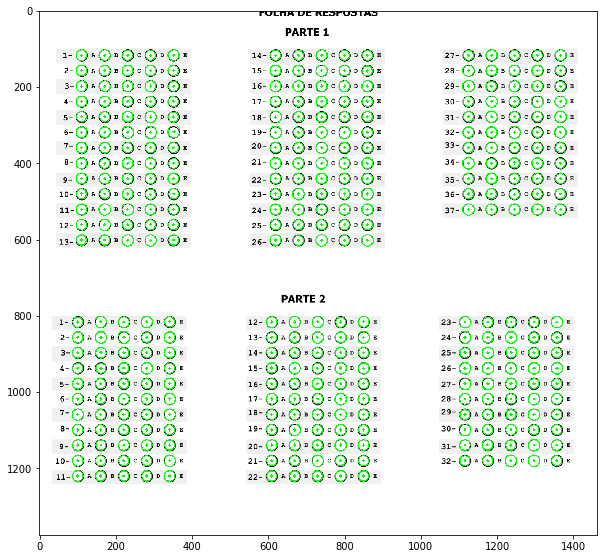

PT_AVALIA_24_32_AE.png


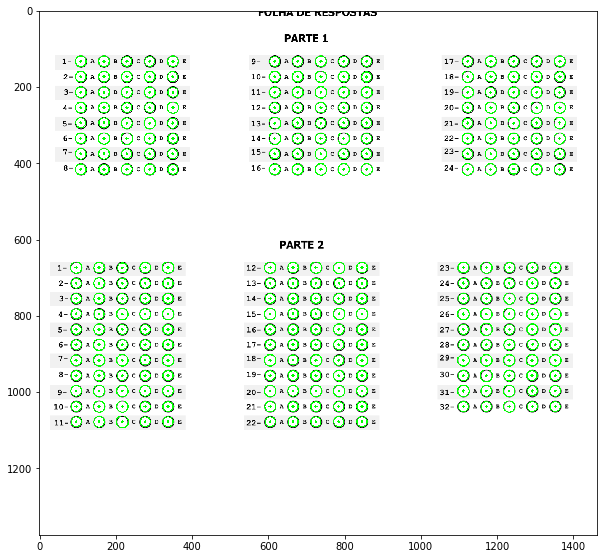

PT_AVALIA_30_32_AE.png


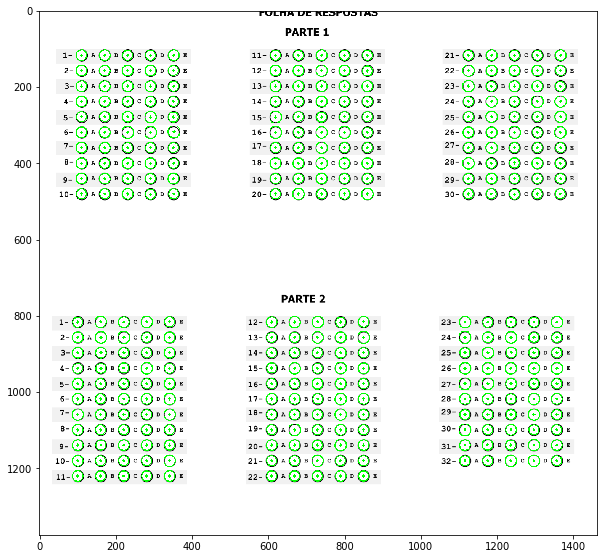

PT_AVALIA_20_32_AE.png


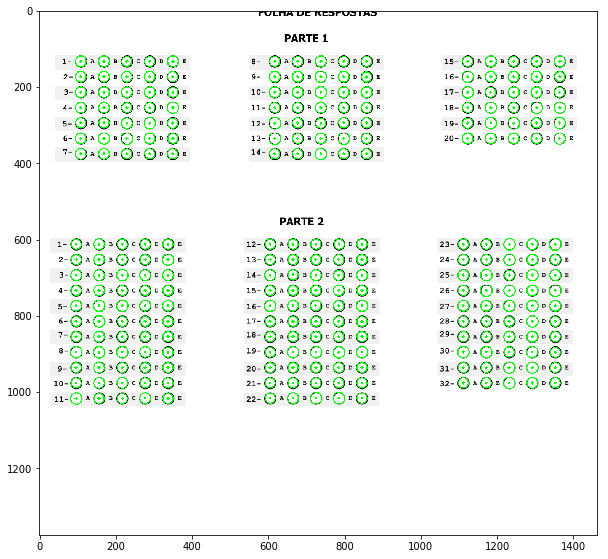

PT_AVALIA_43_32_AE.png


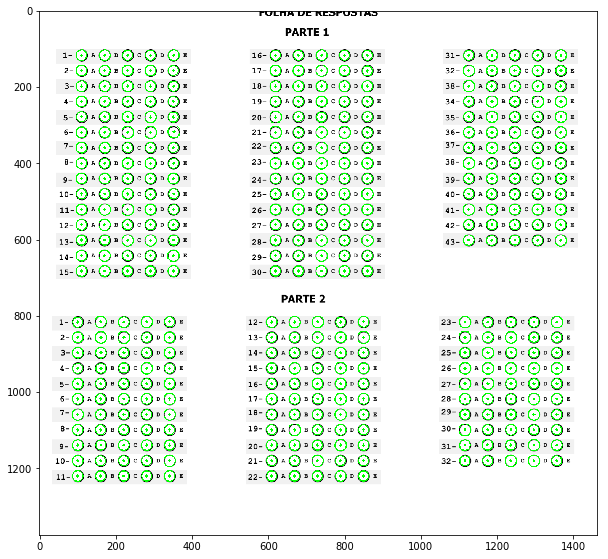

In [120]:
template_path = './templates/png/'
part2 = 40

locations = dict()

for tmp in listdir(template_path):
    if(tmp != '.ipynb_checkpoints'):
        print(tmp)

        template = cv2.imread("{}/{}".format(template_path, tmp))
        warped_tmp = four_point_transform(template, getTips(template, imshow=imshow))
        h,w,c = warped_tmp.shape
        locations[tmp[10:13]] = option_location(warped_tmp[int(0.34*h):int(0.98*h)][:])

## Sample dir

In [52]:
path = 'PDFs_pacote1/png'
imgs = listdir(path) 

## Main

In [67]:
if mult_process:
    
    def process(img):
        print(img)
        image = cv2.imread("{}/{}".format(path, img))
        warped_img = four_point_transform(image, getTips(image, imshow=True))
        warped_img = cv2.resize(warped_img, warped_tmp.shape[0:2][::-1])
        marked_options = marked_option(warped_img[int(0.34*h):][:], option_locations, imshow=True)
        return optins2answer_list(marked_options)

    num_cores = 1 #multiprocessing.cpu_count() // 2
    results = Parallel(n_jobs=num_cores)(delayed(process)(img) for i,img in progressbar(enumerate(imgs)))

In [68]:
if not(mult_process):
    
    results = dict()
    for i,img in progressbar(enumerate(imgs)):

        image = cv2.imread("{}/{}".format(path, img))
        if imshow: show(image)
            
        warped_img = four_point_transform(image, getTips(image, imshow=imshow))
        warped_img = cv2.resize(warped_img, warped_tmp.shape[0:2][::-1])
        marked_options = marked_option(warped_img[int(0.34*h):][:], option_locations, imshow=imshow)
        
        results[img] = optins2answer_list(marked_options)

SyntaxError: invalid syntax (<ipython-input-68-8faf96b446fc>, line 1)

In [62]:
df = pd.DataFrame.from_dict(results).T
df.to_csv("primeiros_resultados.csv")

In [63]:
df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
40_1723187879441.png,#,#,#,#,#,#,#,#,#,#,...,#,#,#,#,#,#,#,#,#,#
40_17231899081311.png,A,E,A,E,A,D,E,A,E,B,...,B,B,C,B,A,C,B,A,C,D
40_17231807371311.png,D,D,E,A,A,C,A,A,D,E,...,C,C,A,D,A,C,B,A,B,B
40_1723187898441.png,D,E,B,D,C,B,D,A,A,D,...,A,D,E,C,B,A,A,A,B,B
40_1723191232441.png,D,A,B,C,B,B,D,A,D,D,...,C,C,B,A,B,A,A,D,A,A
40_17232126631341.png,D,C,E,D,B,A,B,A,B,A,...,A,D,D,A,A,C,A,D,A,A
40_17231848147631.png,#,#,#,#,#,#,#,#,#,#,...,#,#,#,#,#,#,#,#,#,#
40_17231899411311.png,D,C,E,A,A,B,C,A,D,B,...,B,D,A,D,A,D,A,B,B,A
40_1723187293561.png,D,E,A,B,B,C,C,D,A,#,...,B,C,D,B,B,C,B,A,B,B
40_17231911201311.png,*,C,E,A,A,B,C,A,C,E,...,D,C,A,B,A,C,B,A,D,A
